# Introduction

Cycling is probably the only enjoyable (and safe!) mode of travel during this time. And what can be more enjoyable than cycling in the beautiful English countryside? Especially when the sun is out and you can really appreciate the perfect balance between manicure and wilderness, achieved through hundreds of years of hard work...

The other ingredient is all the historic buildings, memorials and small curiosities you can see along the way. During my previous trips, I often wondered how many of these points of interest are just a couple of minutes away from my route. Sometimes you even see an interesting architectural feature and wonder if it merits a digression.  

[OpenStreetMap](www.openstreetmap.org) is a treasure trove of community-sourced data that is available through an open API. With some time on my hands during the lockdown, I decided to explore what is possible with my limited Python skills. And the result was surprisingly usable, some may even say polished. So I decided to publish it for the benefit of my fellow cyclists.

*Just one photo to keep you reading...*
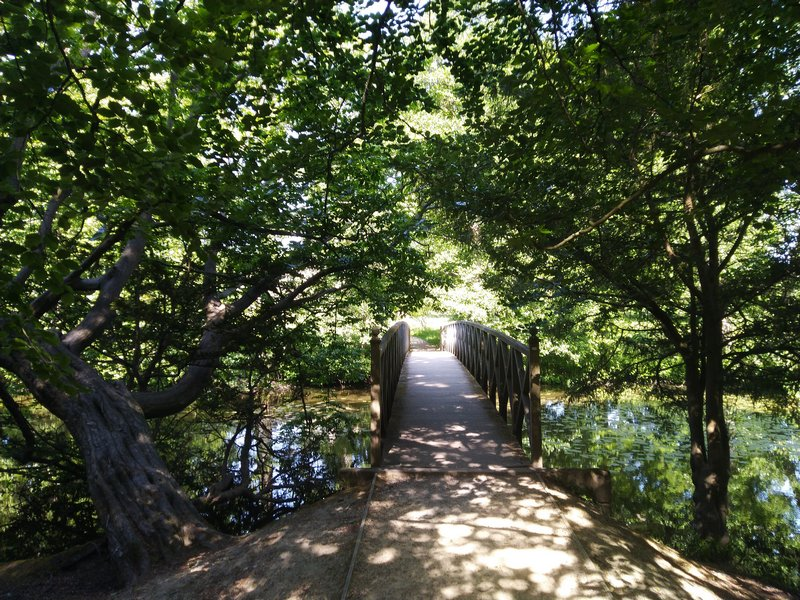

# Preparation and basic mapping/routing

So, let's get into it.  First, import the necessary modules (I strongly recommend to set up a separate conda virtual environment, so yo don't mess up the dependencies of your working environment):

In [1]:
from openrouteservice import client, directions
import folium
from shapely.geometry import LineString, Polygon, mapping, Point
from shapely.ops import cascaded_union, transform
import time
import pyproj
import networkx as nx
import osmnx as ox
import requests
import ipywidgets as widgets

We will need to transform our coordinates data between lat/lon projection (in degrees) and distance projection (in meters). Here are pyproj helper functions to do that:

In [ ]:
project_to_m = pyproj.Transformer.from_proj(
    pyproj.Proj(init='epsg:4326'), # source coordinate system
    pyproj.Proj(init='epsg:32632')) # destination coordinate system

project_to_deg = pyproj.Transformer.from_proj(
    pyproj.Proj(init='epsg:32632'),
    pyproj.Proj(init='epsg:4326'), # source coordinate system
    ) # destination coordinate system

In [3]:
def style_function(color): # To style data
    return lambda feature: dict(color=color,
                                opacity=0.5,
                                weight=4,)

Get OSM coordinates for the start and the finish of our trip. For this example, we are riding from London Bridge to a beautiful one-street (yes, it literally has one street) village of [Chiddingstone](https://www.nationaltrust.org.uk/chiddingstone-village), home of [the Chiding Stone](https://www.nationaltrust.org.uk/chiddingstone-village/features/the-chiding-stone).

In [4]:
address_start = 'London Bridge Station'
address_end = 'Chiddingstone, Kent'
coord_start = ox.geocode(address_start)
coord_end = ox.geocode(address_end) 
[coord_start, coord_end]

[(51.5050313, -0.0858923), (51.1858536, 0.1459325)]

Now let's request a regular cycling route between these points from OpenRouteService (ORS) and show it on the map.
If you don't have an API key, you can request it at https://openrouteservice.org/sign-up  

One thing to note is that mapping functions (Folium) accept input coordinates in Lat/Lon format, while the routing service accepts them in Lon/Lat format. So you need to reverse each coordinate tuple several times alog the way. 

In [24]:
api_key = 'YOUR_ORS_KEY' 
clnt = client.Client(key=api_key)

map_route= folium.Map(tiles='OpenStreetMap', 
                        location=list(coord_start), #LAT-LON
                        zoom_start=13.5,
                     control_scale = True) # Create map

popup_route = "<h4>{0} route</h4><hr>" \
             "<strong>Duration: </strong>{1:.1f} mins<br>" \
             "<strong>Distance: </strong>{2:.3f} km" 

# Request route
coord_start_lon_lat = list(coord_start)
coord_start_lon_lat.reverse()

coord_end_lon_lat = list(coord_end)
coord_end_lon_lat.reverse()

coordinates = [coord_start_lon_lat, coord_end_lon_lat] #LON-LAT
direction_params = {'coordinates': coordinates,
                    'profile': 'cycling-regular', 
                    'format_out': 'geojson',
                    'preference': 'recommended',
                    'geometry': 'true'}

regular_route = clnt.directions(**direction_params) # Direction request
route_bbox = regular_route['features'][0]['bbox']

# Build popup
distance, duration = regular_route['features'][0]['properties']['summary'].values()
popup = folium.map.Popup(popup_route.format('Regular', 
                                                 duration/60, 
                                                 distance/1000))

gj= folium.GeoJson(regular_route,
                   name='Regular Route',
                   style_function=style_function('blue')) \
          .add_child(popup)\
          .add_to(map_route)


folium.Marker(list(reversed(coordinates[0])), popup='Start').add_to(map_route)
folium.Marker(list(reversed(coordinates[1])), popup='End').add_to(map_route)
map_route.fit_bounds([coord_start,  coord_end], padding = (10,10))
map_route

# Define the search area

So far, so good! But we don't just want to cycle from A to B. We want to see some interesting stuff along the way - maybe historical buildings, like castles and manors, tourist attractions etc. All without straying too far off our route.

So, let's say, we are going to search for Points of Interest (POI) that are no more than 500 meters from our regular route. To do that, we need to define a buffer around the route we generated:

This is a very simple function (that took me a long time to write!) that takes a list of coordinates(in degrees) and radius (in meters) and generates the buffer as a Polygon (in degrees) 

In [9]:
def coordsToBufferPoints(coords, radius):
    polys = []
    for c in coords:
        pointInitial = transform(project_to_m.transform, Point(c))
        polys.append(pointInitial.buffer(radius))

    polyBuffer = cascaded_union(polys)
    polyResult = transform(project_to_deg.transform, polyBuffer)
    
    return polyResult

Let's visualize the buffer on the map to make sure we got what we wanted

In [10]:
map_route_buffer = folium.Map(tiles='OpenStreetMap',
                              location=list(coord_start),  # LAT-LON
                              zoom_start=13.5,
                              control_scale=True)  # Create map

popup_route = "<h4>{0} route</h4><hr>" \
    "<strong>Duration: </strong>{1:.1f} mins<br>" \
    "<strong>Distance: </strong>{2:.3f} km"

# Build popup
distance, duration = regular_route['features'][0]['properties']['summary'].values(
)
popup = folium.map.Popup(popup_route.format('Regular',
                                            duration/60,
                                            distance/1000))

gj = folium.GeoJson(regular_route,
                    name='Regular Route',
                    style_function=style_function('blue')) \
    .add_child(popup)\
    .add_to(map_route_buffer)

routeCoords = regular_route['features'][0]['geometry']['coordinates']

routeBuffer = coordsToBufferPoints(routeCoords, 500)

gjBuffer = folium.GeoJson(routeBuffer,
                          name='Regular Route',
                          style_function=style_function('green')) \
    .add_to(map_route_buffer)

folium.Marker(list(reversed(coordinates[0])), popup='Start').add_to(
    map_route_buffer)
folium.Marker(list(reversed(coordinates[1])), popup='End').add_to(
    map_route_buffer)
map_route_buffer.fit_bounds([coord_start,  coord_end], padding=(10, 10))
map_route_buffer

Great!   
Now, let's find these POIs.  
Here are the OSM tags we are interested in:

In [11]:
tagsRoute = {'tourism': 'attraction',
            'historic':True,
            'building':'castle'}

Getting the POIs inside a polygon with OSMnx is just one function call:

In [13]:
routePOI = ox.pois_from_polygon(routeBuffer, tagsRoute)
len(routePOI)

78

Oooh, 78 items! This will be a trip to remember!  
But upon closer inspection, a lot of these Points of Interest are... well, not so interesting.  
Actually, there is a lot of trash.

In [15]:
routePOI.head(10)

,osmid,geometry,highway,element_type,crossing,traffic_signals:direction,maxspeed,name,rcn,rcn_name,...,roof:shape,fortification_type,water,year,source:rcn,access:conditional,ways,alt_name:es,fee,payment:cash
25620776,25620776,POINT (-0.07639 51.50736),NaN,node,NaN,NaN,NaN,Groups Entrance to the Tower,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33149297,33149297,POINT (-0.04698 51.46148),mini_roundabout,node,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33149335,33149335,POINT (-0.05012 51.46602),mini_roundabout,node,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
252602371,252602371,POINT (-0.08826 51.50639),NaN,node,NaN,NaN,NaN,London Bridge Experience,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
269863072,269863072,POINT (-0.07434 51.50158),NaN,node,NaN,NaN,NaN,Jacob,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
417304116,417304116,POINT (-0.04868 51.46063),NaN,node,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
420783219,420783219,POINT (0.01109 51.40490),NaN,node,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
445816914,445816914,POINT (0.05284 51.33113),NaN,node,NaN,NaN,NaN,The Wormstone,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
635975585,635975585,POINT (-0.08670 51.50597),NaN,node,NaN,NaN,NaN,London Bridge Experience,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
691387457,691387457,POINT (-0.07848 51.50796),NaN,node,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Filter the POIs and update the route

So we need to filter this list and select some meaningful fields from hundreds of columns returned from OSM

In [16]:
routePOIFilter = routePOI[['element_type',
                           'name',
                           'historic',
                           'tourism',
                           'wikipedia',
                           'amenity',
                           'memorial',
                           'description',
                           'building',
                           'osmid',
                           'geometry']].dropna(thresh=5)

routePOIFilter.head(10)

,element_type,name,historic,tourism,wikipedia,amenity,memorial,description,building,osmid,geometry
252602371,node,London Bridge Experience,NaN,attraction,en:The London Bridge Experience,NaN,NaN,NaN,NaN,252602371,POINT (-0.08826 51.50639)
269863072,node,Jacob,memorial,NaN,NaN,NaN,NaN,The circle dray horse,NaN,269863072,POINT (-0.07434 51.50158)
445816914,node,The Wormstone,archaeological_site,NaN,NaN,NaN,NaN,NaN,NaN,445816914,POINT (0.05284 51.33113)
635975585,node,London Bridge Experience,NaN,attraction,NaN,NaN,NaN,NaN,NaN,635975585,POINT (-0.08670 51.50597)
945300377,node,Scottish Martyrs monument,memorial,NaN,NaN,NaN,obelisk,NaN,NaN,945300377,POINT (-0.05313 51.46375)
963510071,node,Merchant Taylors' School,memorial,NaN,NaN,NaN,blue_plaque,NaN,NaN,963510071,POINT (-0.09199 51.50833)
1048497151,node,Ernest Bevan,memorial,NaN,NaN,NaN,NaN,NaN,NaN,1048497151,POINT (-0.07796 51.50284)
1048497367,node,Samuel Bourne Bevington,memorial,NaN,NaN,NaN,NaN,NaN,NaN,1048497367,POINT (-0.07810 51.50290)
1657480036,node,Weardale Manor,ruins,NaN,NaN,NaN,NaN,NaN,NaN,1657480036,POINT (0.10145 51.24636)
1676037001,node,The Chiding Stone,archaeological_site,NaN,NaN,NaN,NaN,NaN,NaN,1676037001,POINT (0.14589 51.18535)


Now, this is much better. But still, not all of these points really warrant a detour. So we will select a subset of them we are really interested in and will add them to the route.  

We can make the whole process really seamless using the Jupyter interactive widget system.

In [17]:
checkboxList = []
columnsCheck = ['historic', 'wikipedia', 'amenity', 'memorial', 'description']
start = list(coord_start)
end = list(coord_end)
coordsUpdatedSorted = []
namesUpdatedSorted = []


def routeUpdate(b):
    global coordsUpdatedSorted, namesUpdatedSorted
    coordsUpdated = []
    namesUpdated = []
    distFromStart = []

    for i in range(len(checkboxList)):
        if checkboxList[i].value == True:
            poiAdd = routePOIFilter.iloc[i]
            namesUpdated.append(poiAdd['name'])

            if poiAdd.element_type == 'node':
                coordAdd = [float(poiAdd.geometry.y),
                            float(poiAdd.geometry.x)]
            else:
                coordAdd = [float(poiAdd.geometry.centroid.y),
                            float(poiAdd.geometry.centroid.x)]
            coords = start + coordAdd
            dist = ox.distance.great_circle_vec(*coords)
            distFromStart.append(dist)
            coordsUpdated.append(coordAdd)

    # We need to sort any points we add to the route by distance from the starting point.
    # Otherwise, we will end with a hodge-podge of randomly selected points

    coordsUpdatedSorted = [c[1] for c in sorted(
        zip(distFromStart, coordsUpdated), key=lambda x: x[0])]
    coordsUpdatedSorted = [start] + coordsUpdatedSorted + [end]

    namesUpdatedSorted = [c[1] for c in sorted(
        zip(distFromStart, namesUpdated), key=lambda x: x[0])]
    namesUpdatedSorted = [address_start] + namesUpdatedSorted + [address_end]
    
    print(coordsUpdatedSorted)
    return coordsUpdatedSorted


for i in range(len(routePOIFilter)):

    item = routePOIFilter.iloc[i]
    desc = str(item['name'])

    for c in columnsCheck:
        if type(item[c]) == str:
            desc = desc + ' ' + c+':'+item[c]

    checkboxList.append(widgets.Checkbox(
        value=False,
        description=desc,
        disabled=False,
        indent=False,
        layout=widgets.Layout(width='100%')
    ))
buttonUpdate = widgets.Button(
    description='Update route',
    disabled=False,
    button_style='', 
    tooltip='Add selected POIs to the route',
    icon='update'  
)

buttonUpdate.on_click(routeUpdate)

widgetPOIcheck = widgets.VBox(
    checkboxList+[buttonUpdate], layout=widgets.Layout(width='100%'))


widgetPOIcheck

[[51.5050313, -0.0858923], [51.503969155372445, -0.09325539799998009], [51.5015841, -0.0743414], [51.4637547, -0.0531279], [51.46308880000001, -0.0511468], [51.3510888399767, 0.030053528946478628], [51.3508184, 0.0373899], [51.33450105290082, 0.05585272964791204], [51.3311335, 0.0528395], [51.246361, 0.1014503], [51.18576100547525, 0.14227140698558516], [51.1853518, 0.1458905], [51.1858536, 0.1459325]]


The last step is to request the new route, which will include all selected points, and visualize it on the map again (including the POI markers):

In [25]:
map_route_updated = folium.Map(tiles='OpenStreetMap',
                               location=(coordsUpdatedSorted[0]),  # LAT-LON
                               zoom_start=13.5,
                               control_scale=True)  # Create map

popup_route = "<h4>{0} route</h4><hr>" \
    "<strong>Duration: </strong>{1:.1f} mins<br>" \
    "<strong>Distance: </strong>{2:.3f} km"

# Request route

coordinates_lon_lat = [[c[1], c[0]] for c in coordsUpdatedSorted]  # LON-LAT

direction_params = {'coordinates': coordinates_lon_lat,
                    'profile': 'cycling-regular',
                    'format_out': 'geojson',
                    'preference': 'recommended',
                    'geometry': 'true'}

updated_route = clnt.directions(**direction_params)  # Direction request
route_bbox = regular_route['features'][0]['bbox']

# Build popup
distance, duration = updated_route['features'][0]['properties']['summary'].values(
)
popup = folium.map.Popup(popup_route.format('Regular',
                                            duration/60,
                                            distance/1000))

gj = folium.GeoJson(regular_route,
                    name='Regular Route',
                    style_function=style_function('blue')) \
    .add_child(popup)\
    .add_to(map_route_updated)

routeCoords = updated_route['features'][0]['geometry']['coordinates']

for i in range(len(namesUpdatedSorted)):
    folium.Marker(coordsUpdatedSorted[i], popup=namesUpdatedSorted[i]).add_to(
        map_route_updated)

map_route_updated.fit_bounds(
    [coordsUpdatedSorted[0], coordsUpdatedSorted[-1]], padding=(10, 10))
map_route_updated

You could notice that not all POIs are actually ON the route. This is not surprising, given some of them are in areas not reachable by bike. But they are all close enough to visit/observe.

You can even download the route as a GPX file to load into your navigator

In [23]:
body = {"coordinates": coordinates_lon_lat, "preference": "recommended"}

headers = {
    'Accept': 'application/json, application/geo+json, application/gpx+xml, img/png; charset=utf-8',
    'Authorization': '5b3ce3597851110001cf62484bacb83d2107475198ea22650a25b872',
    'Content-Type': 'application/json; charset=utf-8'
}
call = requests.post(
    'https://api.openrouteservice.org/v2/directions/cycling-regular/gpx', json=body, headers=headers)

print(call.status_code, call.reason)
print('GPX route received, ', str(len(call.text)), ' bytes')

200 OK
GPX route received,  310806  bytes


In [20]:
with open('./route.gpx', 'w') as f:
    f.write(call.text)

That's it! Hope you did find it useful!